In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "3, 4"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc, DIRECT_ACC
from jdgsim.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits
from jdgsim.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=100_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                 r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                 c = 10,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=100000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=0.010000000000000002, integrator=0, acceleration_scheme=0, batch_size=10000, double_map=False, external_accelerations=(0,))
SimulationParams(G=1, t_end=6.7070874092034565, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=10000.0, r_s=2.0, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28))


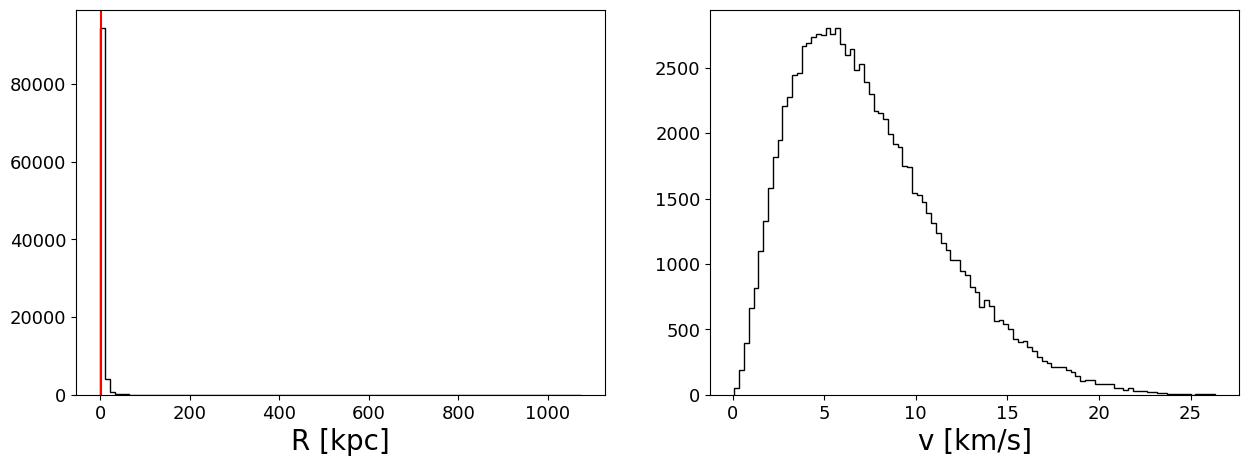

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
#put the Plummer sphere in a ciruclar orbit around the NFW halo
rp=100*u.kpc.to(code_units.code_length)

mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

if len(config.external_accelerations)>0:
    pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
    velocities = velocities + vel[1]
    positions = positions + pos[1]

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [6]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))


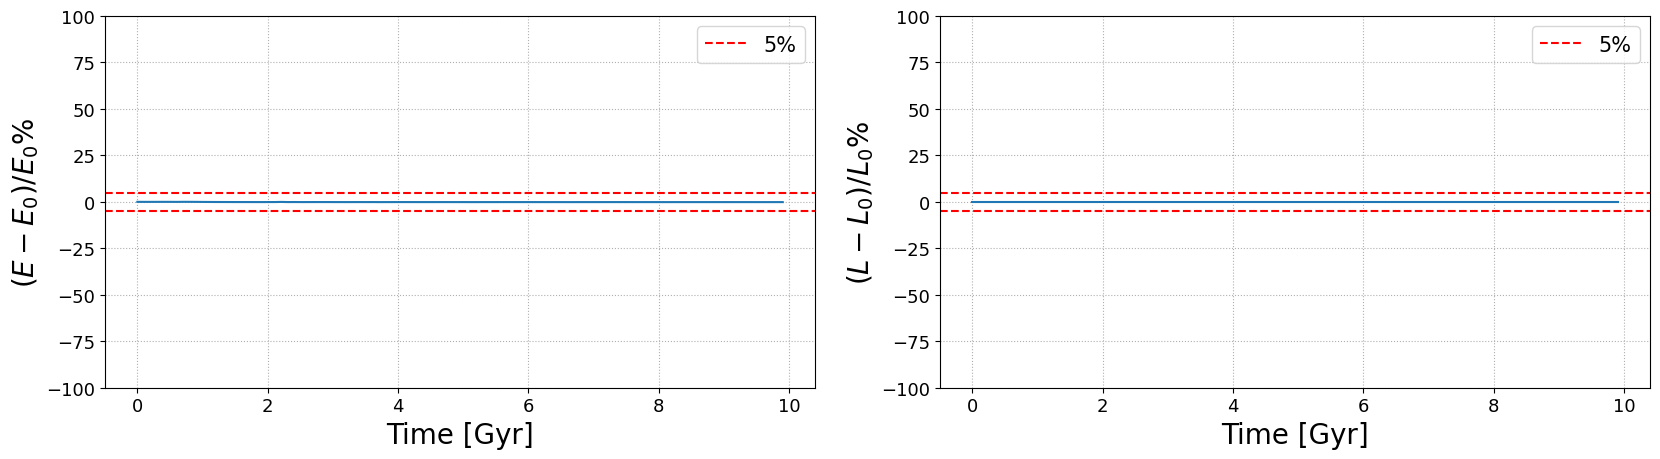

In [7]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_Plummer_in_NFWpotential.pdf')

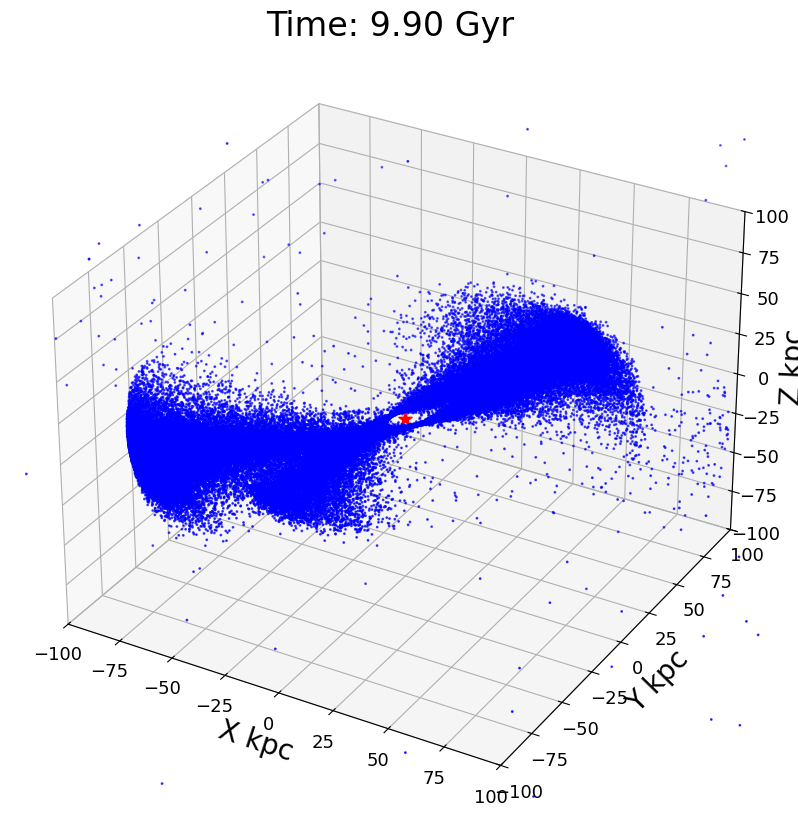

In [8]:
create_3d_gif(snapshots, 
              ax_lim=rp, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='./visualization/gif/simulation_Plummer_in_NFWpotential.gif')

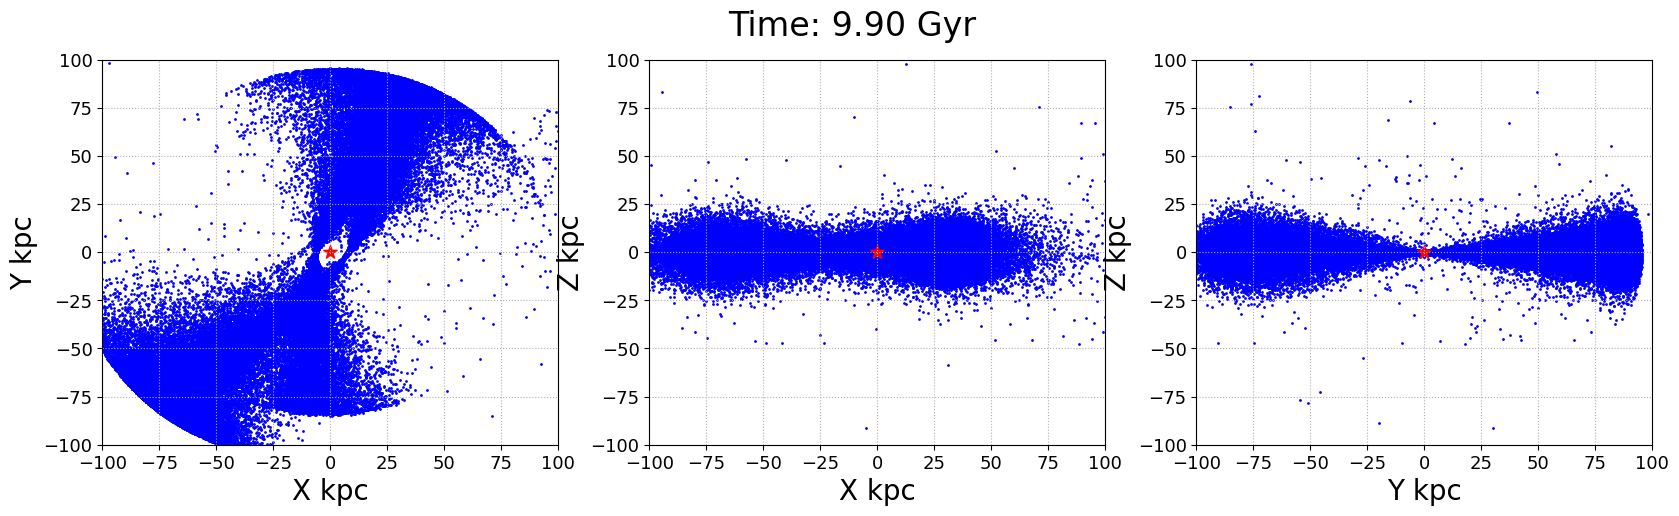

In [9]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=rp, 
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='./visualization/gif/simulation_projection_Plummer_in_NFWpotential.gif')